# Part 1: Detection of Fake / Real Profiles 

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
from pandas_profiling import ProfileReport
import keras as k
from sklearn.model_selection import train_test_split
import keras
from keras import regularizers
from keras.models import Sequential,model_from_json
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from numpy.random import seed
seed(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Read dataset

In [ ]:
df_users = pd.read_csv("/content/dataset/users.csv")
df_fusers = pd.read_csv("/content/dataset/fusers.csv")

In [ ]:
df_fusers.shape

(3351, 38)

In [ ]:
df_users.shape

(3474, 42)

# Add isFake Column

In [ ]:
#for df_users
isNotFake = np.zeros(3474)

#for df_fusers
isFake = np.ones(3351)

In [ ]:
#adding is fake or not column to make predictions for it
df_fusers["isFake"] = isFake
df_users["isFake"] = isNotFake


# Combine different datasets into one

In [ ]:
df_allUsers = pd.concat([df_fusers, df_users], ignore_index=True)
df_allUsers.columns = df_allUsers.columns.str.strip()

In [ ]:
#to shuffle the whole data
df_allUsers = df_allUsers.sample(frac=1).reset_index(drop=True)

In [ ]:
df_allUsers.describe()

,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,contributors_enabled,following,isFake,test_set_1,test_set_2
count,6.825000e+03,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,4066.0,19.0,2294.0,6426.0,1477.0,2810.000000,1.0,0.0,78.0,11.0,0.0,0.0,0.0,6825.000000,3474.000000,3474.000000
mean,8.499737e+08,8667.221685,717.874432,504.022564,2378.999121,9.959853,1.0,1.0,1.0,1.0,1.0,-4889.145907,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0.490989,0.287853,0.141048
std,7.662248e+08,23473.945131,12301.657025,1159.286294,8548.235726,112.952257,0.0,0.0,0.0,0.0,0.0,22037.451204,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.499955,0.452827,0.348121
min,6.780330e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-39600.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,2.597067e+08,23.000000,12.000000,206.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-25200.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,6.168972e+08,190.000000,33.000000,312.000000,10.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-14400.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0.000000,0.000000,0.000000
75%,1.174963e+09,6900.000000,349.000000,555.000000,1360.000000,2.000000,1.0,1.0,1.0,1.0,1.0,13500.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,0.000000
max,3.164942e+09,399555.000000,986837.000000,46310.000000,313954.000000,6166.000000,1.0,1.0,1.0,1.0,1.0,46800.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.000000,1.000000,1.000000


In [ ]:
df_allUsers.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,lang,time_zone,location,default_profile,default_profile_image,geo_enabled,profile_image_url,profile_banner_url,profile_use_background_image,profile_background_image_url_https,profile_text_color,profile_image_url_https,profile_sidebar_border_color,profile_background_tile,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,description,contributors_enabled,following,updated,isFake,timestamp,crawled_at,test_set_1,test_set_2
0,154856763,olobnew1,olobnew1,0,3,502,0,0,Sat Jun 12 11:39:51 +0000 2010,NaN,en,NaN,NaN,1.0,NaN,NaN,http://a0.twimg.com/profile_images/2358771708/...,NaN,1.0,https://twimg0-a.akamaihd.net/images/themes/th...,333333,https://twimg0-a.akamaihd.net/profile_images/2...,C0DEED,NaN,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-12 18:38:35,1.0,NaN,NaN,NaN,NaN
1,1130403349,Rocky Coffey,RockyCoffey1,20,12,241,0,0,Tue Jan 29 08:05:57 +0000 2013,NaN,en,NaN,the nebula,1.0,NaN,NaN,http://a0.twimg.com/profile_images/3295107972/...,NaN,1.0,https://si0.twimg.com/images/themes/theme1/bg.png,333333,https://si0.twimg.com/profile_images/329510797...,C0DEED,NaN,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,NaN,NaN,NaN,#teamfollowback becaue yo want to .,NaN,NaN,2013-06-12 18:38:35,1.0,NaN,NaN,NaN,NaN
2,618758991,Tashina Oconnor,tashinabwg,20,11,282,0,0,Tue Jun 26 03:14:10 +0000 2012,NaN,en,NaN,Venezuela,1.0,NaN,NaN,http://a0.twimg.com/profile_images/2997663065/...,NaN,1.0,https://si0.twimg.com/images/themes/theme1/bg.png,333333,https://si0.twimg.com/profile_images/299766306...,C0DEED,NaN,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,NaN,NaN,NaN,"Reggaeton, Rp, Hip - Hop R& 24/7",NaN,NaN,2013-06-12 18:38:35,1.0,NaN,NaN,NaN,NaN
3,2387366902,Ceddie ✨,HannahCedra,5361,435,375,1193,0,Thu Mar 06 04:34:47 +0000 2014,NaN,en,NaN,NaN,1.0,NaN,NaN,http://pbs.twimg.com/profile_images/5779482992...,https://pbs.twimg.com/profile_banners/23873669...,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://pbs.twimg.com/profile_images/577948299...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,1.0,NaN,NaN,UofM17 BusinessMajor- Accountingsnapchat: cedr...,NaN,NaN,2016-03-15 15:56:46,0.0,2014-03-06 05:34:47,2015-05-01 12:56:24,0.0,0.0
4,555411470,salman Ali,MSalmanAli96,17732,1013,693,9557,1,Mon Apr 16 20:47:58 +0000 2012,NaN,en,NaN,Islamabad,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/5516773506...,https://pbs.twimg.com/profile_banners/55541147...,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://pbs.twimg.com/profile_images/551677350...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,4A913C,NaN,NaN,NaN,NaN,NaN,NaN,Keep Calm and wait for your turn #ShiaGenocide...,NaN,NaN,2016-03-15 15:58:29,0.0,2012-04-16 22:47:58,2015-05-01 13:59:39,1.0,1.0


# Distribution of Data in X and Y

In [ ]:
Y = df_allUsers.isFake

In [ ]:
df_allUsers.drop(["isFake"], axis=1, inplace=True)
X = df_allUsers

In [ ]:
profile = ProfileReport(X, title="Pandas Profiling Report")
profile

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Y.reset_index(drop=True, inplace=True)

In [ ]:
print(Y.shape)

(6825,)


In [ ]:
X.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,lang,time_zone,location,default_profile,default_profile_image,geo_enabled,profile_image_url,profile_banner_url,profile_use_background_image,profile_background_image_url_https,profile_text_color,profile_image_url_https,profile_sidebar_border_color,profile_background_tile,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,description,contributors_enabled,following,updated,timestamp,crawled_at,test_set_1,test_set_2
0,154856763,olobnew1,olobnew1,0,3,502,0,0,Sat Jun 12 11:39:51 +0000 2010,NaN,en,NaN,NaN,1.0,NaN,NaN,http://a0.twimg.com/profile_images/2358771708/...,NaN,1.0,https://twimg0-a.akamaihd.net/images/themes/th...,333333,https://twimg0-a.akamaihd.net/profile_images/2...,C0DEED,NaN,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-12 18:38:35,NaN,NaN,NaN,NaN
1,1130403349,Rocky Coffey,RockyCoffey1,20,12,241,0,0,Tue Jan 29 08:05:57 +0000 2013,NaN,en,NaN,the nebula,1.0,NaN,NaN,http://a0.twimg.com/profile_images/3295107972/...,NaN,1.0,https://si0.twimg.com/images/themes/theme1/bg.png,333333,https://si0.twimg.com/profile_images/329510797...,C0DEED,NaN,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,NaN,NaN,NaN,#teamfollowback becaue yo want to .,NaN,NaN,2013-06-12 18:38:35,NaN,NaN,NaN,NaN
2,618758991,Tashina Oconnor,tashinabwg,20,11,282,0,0,Tue Jun 26 03:14:10 +0000 2012,NaN,en,NaN,Venezuela,1.0,NaN,NaN,http://a0.twimg.com/profile_images/2997663065/...,NaN,1.0,https://si0.twimg.com/images/themes/theme1/bg.png,333333,https://si0.twimg.com/profile_images/299766306...,C0DEED,NaN,DDEEF6,http://a0.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,NaN,NaN,NaN,"Reggaeton, Rp, Hip - Hop R& 24/7",NaN,NaN,2013-06-12 18:38:35,NaN,NaN,NaN,NaN
3,2387366902,Ceddie ✨,HannahCedra,5361,435,375,1193,0,Thu Mar 06 04:34:47 +0000 2014,NaN,en,NaN,NaN,1.0,NaN,NaN,http://pbs.twimg.com/profile_images/5779482992...,https://pbs.twimg.com/profile_banners/23873669...,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://pbs.twimg.com/profile_images/577948299...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,1.0,NaN,NaN,UofM17 BusinessMajor- Accountingsnapchat: cedr...,NaN,NaN,2016-03-15 15:56:46,2014-03-06 05:34:47,2015-05-01 12:56:24,0.0,0.0
4,555411470,salman Ali,MSalmanAli96,17732,1013,693,9557,1,Mon Apr 16 20:47:58 +0000 2012,NaN,en,NaN,Islamabad,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/5516773506...,https://pbs.twimg.com/profile_banners/55541147...,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://pbs.twimg.com/profile_images/551677350...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,4A913C,NaN,NaN,NaN,NaN,NaN,NaN,Keep Calm and wait for your turn #ShiaGenocide...,NaN,NaN,2016-03-15 15:58:29,2012-04-16 22:47:58,2015-05-01 13:59:39,1.0,1.0


In [ ]:
lang_list = list(enumerate(np.unique(X["lang"])))
lang_dict = {name : i for i, name in lang_list}
X.loc[:, "lang_num"] = X["lang"].map(lambda x: lang_dict[x]).astype(int)

X.drop(["name"], axis=1, inplace=True)

# Feature Selection

In [ ]:
X = X[[
    "statuses_count",
    "followers_count",
    "friends_count",
    "favourites_count",
    "lang_num",
    "listed_count",
    "geo_enabled",
    "profile_use_background_image"
                        ]]

In [ ]:
profile = ProfileReport(X, title="Pandas Profiling Report")
profile

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X = X.replace(np.nan, 0) #To replace the missing boolean values with zeros as it means false

In [ ]:
profile = ProfileReport(X, title="Pandas Profiling Report")
profile

Output hidden; open in https://colab.research.google.com to view.

# Import Data

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(4368, 8)
(1365, 8)
(4368,)
(1365,)


# Design Model

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=8))
model.add(Dense(64, input_dim=32, activation='relu'))
model.add(Dense(64, input_dim=64, activation='relu'))
model.add(Dense(32,input_dim=64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 8,673
Trainable params: 8,673
Non-trainable params: 0
_________________________________________________________________


# Compile Model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training

In [ ]:
history = model.fit(train_X, train_y,
                    epochs=15,
                    verbose=1,
                    validation_data=(val_X,val_y))

Train on 4368 samples, validate on 1092 samples
Epoch 1/15
4368/4368 [==============================] - 2s 562us/step - loss: 0.9832 - accuracy: 0.9732 - val_loss: 4.1833 - val_accuracy: 0.9835
Epoch 2/15
4368/4368 [==============================] - 1s 156us/step - loss: 0.4890 - accuracy: 0.9803 - val_loss: 1.3658 - val_accuracy: 0.9808
Epoch 3/15
4368/4368 [==============================] - 1s 156us/step - loss: 0.3450 - accuracy: 0.9787 - val_loss: 1.0589 - val_accuracy: 0.9808
Epoch 4/15
4368/4368 [==============================] - 1s 156us/step - loss: 0.2470 - accuracy: 0.9762 - val_loss: 1.7244 - val_accuracy: 0.9844
Epoch 5/15
4368/4368 [==============================] - 1s 155us/step - loss: 0.1826 - accuracy: 0.9821 - val_loss: 0.6196 - val_accuracy: 0.9835
Epoch 6/15
4368/4368 [==============================] - 1s 154us/step - loss: 0.1695 - accuracy: 0.9799 - val_loss: 0.7708 - val_accuracy: 0.9808
Epoch 7/15
4368/4368 [==============================] - 1s 156us/step - loss

# Testing

In [ ]:
score = model.evaluate(test_X, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08420868816311325
Test accuracy: 0.9824175834655762


# Graphs

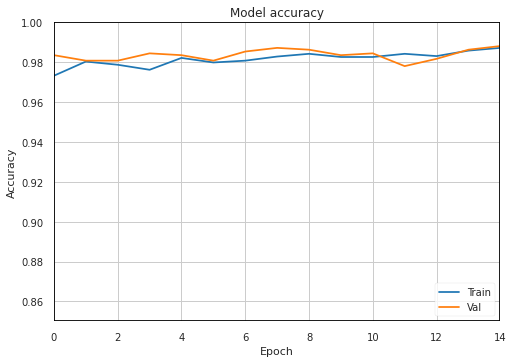

In [ ]:
# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
axes = plt.gca()
axes.set_xlim([0,14])
axes.set_ylim([0.85,1])
axes.grid(True, which='both')
axes.axhline(y=0.85, color='k')
axes.axvline(x=0, color='k')
axes.axvline(x=14, color='k')
axes.axhline(y=1, color='k')
plt.legend(['Train','Val'], loc='lower right')
plt.show()

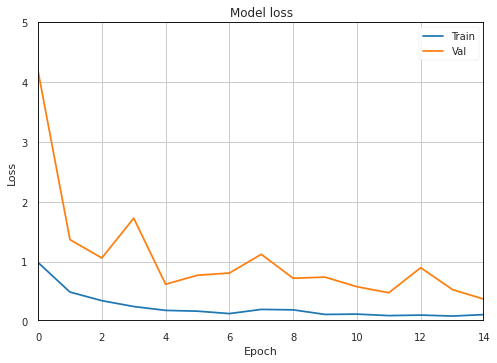

In [ ]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
axes = plt.gca()
axes.set_xlim([0,14])
axes.set_ylim([0,5])
axes.grid(True, which='both')
axes.axhline(y=0, color='k')
axes.axvline(x=0, color='k')
axes.axhline(y=5, color='k')
axes.axvline(x=14, color='k')
plt.legend(['Train','Val'], loc='upper right')
plt.show()

# Prediction

In [ ]:
# Write the index of the test sample to test
prediction = model.predict(test_X[136:137])
prediction = prediction[0]
print('Prediction\n',prediction)
print('\nThresholded output\n',(prediction>0.5)*1)

Prediction
 [0.9901119]

Thresholded output
 [1]


# Ground truth

In [ ]:
print(test_y[136:137])

5389    1.0
Name: isFake, dtype: float64


# Part 2: Saving, Loading Model

# Saving

In [ ]:
# serialize model to JSON
model_json = model.to_json()

# Write the file name of the model

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
# Write the file name of the weights

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Loading

In [ ]:
# load json and create model

# Write the file name of the model

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
# Write the file name of the weights

loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
